In [11]:
!pwd

/Users/mike/Documents/Project/FedWeight/FedWeight_eICU/notebook/etm


In [12]:
import os

# Change the directory to your scratch folder
# os.chdir('/scratch/mikezhu/fed_weight_jupyter/notebook')
# os.chdir('/scratch/mikezhu/fed_weight_jupyter/notebook')

In [13]:
!pwd

/Users/mike/Documents/Project/FedWeight/FedWeight_eICU/notebook/etm


In [14]:
import torch
import numpy as np
import random

# Set the seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

In [15]:
import pandas as pd

icd_data = pd.read_csv("../../data/eicu_mimic_patient_diagnosis.csv")
icd_code_names = icd_data.columns[4:]

/var/folders/wd/d0j10lq906x4lfc0bphzybd80000gn/T/ipykernel_65044/1336925752.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  icd_data = pd.read_csv("../../data/eicu_mimic_patient_diagnosis.csv")


In [16]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
mimic_data = icd_data[icd_data["hospitalid"] == 2001]
eicu_data = icd_data[icd_data["hospitalid"] == 1001]

mimic_icds = mimic_data.iloc[:, 4:].to_numpy()
eicu_icds = eicu_data.iloc[:, 4:].to_numpy()

In [18]:
t_hidden_size = 512
rho_size = 512
num_topics = 64
enc_drop = 0.2

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class ETM(nn.Module):
    def __init__(self, num_topics, vocab_size, t_hidden_size, rho_size, enc_drop=0.5):
        super(ETM, self).__init__()

        ## define hyperparameters
        self.num_topics = num_topics
        self.vocab_size = vocab_size
        self.rho_size = rho_size
        self.enc_drop = enc_drop
        self.t_drop = nn.Dropout(enc_drop)

        ## define the word embedding matrix \rho
        self.rho = nn.Linear(rho_size, vocab_size, bias=False)

        # with torch.no_grad():
        #     self.rho.weight = nn.Parameter(pretrained_rho_tensor.T)
        #     self.rho.weight.requires_grad = False

        ## define the matrix containing the topic embeddings
        self.alphas = nn.Linear(rho_size, num_topics, bias=False)

        ## define variational distribution for \theta_{1:D} via amortizartion
        # print(vocab_size, " THE Vocabulary size is here ")
        self.q_theta = nn.Sequential(
                nn.Linear(vocab_size, t_hidden_size),
                nn.ReLU(),
            )

        self.mu_q_theta = nn.Linear(t_hidden_size, num_topics, bias=True)
        self.logsigma_q_theta = nn.Linear(t_hidden_size, num_topics, bias=True)

    def reparameterize(self, mu, logvar):
        """Returns a sample from a Gaussian distribution via reparameterization.
        """
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul_(std).add_(mu)
        else:
            # During inference time, there is no need for random sampling.
            # Instead, the model can use the mean directly, which is a point estimate of the latent variable
            # This avoids unnecessary randomness during inference or testing.
            return mu

    def encode(self, bows):
        """Returns paramters of the variational distribution for \theta.

        input: bows
                batch of bag-of-words...tensor of shape bsz x V
        output: mu_theta, log_sigma_theta
        """
        q_theta = self.q_theta(bows)
        if self.enc_drop > 0:
            q_theta = self.t_drop(q_theta)
        mu_theta = self.mu_q_theta(q_theta)
        logsigma_theta = self.logsigma_q_theta(q_theta)
        kl_theta = -0.5 * torch.sum(1 + logsigma_theta - mu_theta.pow(2) - logsigma_theta.exp(), dim=-1).mean()

        return mu_theta, logsigma_theta, kl_theta

    def get_beta(self):
        """
        This generate the description as a defintion over words

        Returns:
            [type]: [description]
        """
        try:
            logit = self.alphas(self.rho.weight) # torch.mm(self.rho, self.alphas)
        except:
            logit = self.alphas(self.rho)
        # logit = self.alphas(self.rho.weight.T)
        beta = F.softmax(logit, dim=0).transpose(1, 0) ## softmax over vocab dimension
        return beta

    def get_theta(self, normalized_bows, is_train=True, d=1.0):
        """
        getting the topic poportion for the document passed in the normalixe bow or tf-idf"""
        mu_theta, logsigma_theta, kld_theta = self.encode(normalized_bows)
        z = self.reparameterize(mu_theta, logsigma_theta)
        theta = F.softmax(z, dim=-1)
        if not is_train:
            theta = F.softmax(z / d, dim=-1)
        return z, theta, kld_theta

    def decode(self, theta, beta):
        """compute the probability of topic given the document which is equal to theta^T ** B

        Args:
            theta ([type]): [description]
            beta ([type]): [description]

        Returns:
            [type]: [description]
        """
        res = torch.mm(theta, beta)

        almost_zeros = torch.full_like(res, 1e-6)
        results_without_zeros = res.add(almost_zeros)
        predictions = torch.log(results_without_zeros)
        return predictions

    def forward(self, bows, normalized_bows, theta=None, aggregate=True):
        ## get \theta
        if theta is None:
            _, theta, kld_theta = self.get_theta(normalized_bows)
        else:
            kld_theta = None

        ## get \beta
        beta = self.get_beta()

        ## get prediction loss
        preds = self.decode(theta, beta)
        recon_loss = -(preds * bows).sum(1)
        if aggregate:
            recon_loss = recon_loss.mean()
        return recon_loss, kld_theta

In [20]:
import torch
import numpy as np

weighted_mimic_client_model = ETM(num_topics=num_topics,
                       vocab_size=len(icd_code_names),
                       t_hidden_size=t_hidden_size,
                       rho_size=rho_size,
                       enc_drop=enc_drop)
weighted_mimic_client_model.load_state_dict(
    torch.load('../result/fedweight_etm_64mimic_client_model.pth', map_location=device)
)
weighted_mimic_client_model.eval()

weighted_mimic_train_icds = np.load("../result/fedweight_etm_64mimic_train_icds.npy")
weighted_mimic_test_icds = np.load("../result/fedweight_etm_64mimic_test_icds.npy")
weighted_mimic_train_readmit_row_ids = np.load("../result/fedweight_etm_64mimic_train_readmit_row_ids.npy")
weighted_mimic_test_readmit_row_ids = np.load("../result/fedweight_etm_64mimic_test_readmit_row_ids.npy")
weighted_mimic_train_label_deaths = np.load("../result/fedweight_etm_64mimic_train_label_deaths.npy")
weighted_mimic_test_label_deaths = np.load("../result/fedweight_etm_64mimic_test_label_deaths.npy")

weighted_eicu_client_model = ETM(num_topics=num_topics,
                       vocab_size=len(icd_code_names),
                       t_hidden_size=t_hidden_size,
                       rho_size=rho_size,
                       enc_drop=enc_drop)
weighted_eicu_client_model.load_state_dict(
    torch.load('../result/fedweight_etm_64eicu_client_model.pth', map_location=device)
)
weighted_eicu_client_model.eval()

weighted_eicu_train_icds = np.load("../result/fedweight_etm_64eicu_train_icds.npy")
weighted_eicu_test_icds = np.load("../result/fedweight_etm_64eicu_test_icds.npy")
weighted_eicu_train_readmit_row_ids = np.load("../result/fedweight_etm_64eicu_train_readmit_row_ids.npy")
weighted_eicu_test_readmit_row_ids = np.load("../result/fedweight_etm_64eicu_test_readmit_row_ids.npy")
weighted_eicu_train_label_deaths = np.load("../result/fedweight_etm_64eicu_train_label_deaths.npy")
weighted_eicu_test_label_deaths = np.load("../result/fedweight_etm_64eicu_test_label_deaths.npy")

In [21]:
import pandas as pd

def convert_icd9_to_disease(icd_9):
    if pd.isna(icd_9):
        return "Others"
    primary_icd9 = icd_9.split(',')[0].strip()
    try:
        # Convert the input to a float to handle both numeric and decimal ICD-9 codes
        icd_9_float = float(primary_icd9)

        # Check the ICD-9 code against the known ranges
        if 1 <= icd_9_float <= 139.9:
            return "Infection"
        elif 140 <= icd_9_float <= 239.9:
            return "Neoplasms"
        elif 240 <= icd_9_float <= 279.9:
            return "Endocrine"
        elif 280 <= icd_9_float <= 289.9:
            return "Blood"
        elif 290 <= icd_9_float <= 319:
            return "Mental"
        elif 320 <= icd_9_float <= 389.9:
            return "Nervous"
        elif 390 <= icd_9_float <= 459.9:
            return "Circulatory"
        elif 460 <= icd_9_float <= 519.9:
            return "Respiratory"
        elif 520 <= icd_9_float <= 579.9:
            return "Digestive"
        elif 580 <= icd_9_float <= 629.9:
            return "Genitourinary"
        elif 630 <= icd_9_float <= 676.9:
            return "Pregnancy"
        elif 680 <= icd_9_float <= 709.9:
            return "Skin"
        elif 710 <= icd_9_float <= 739.9:
            return "Musculoskeletal"
        elif 740 <= icd_9_float <= 759.9:
            return "Congenital"
        elif 760 <= icd_9_float <= 799.9:
            return "Perinatal"
        elif 800 <= icd_9_float <= 1000:
            return "Poisoning"
        elif icd_9.startswith("V"):
            return "Others"
        else:
            return "Others"
    
    except ValueError:
        return "Others"

disease_color_map = {
    "Infection": "#005896",
    "Neoplasms": "#dc5f00",      # SteelBlue
    "Endocrine": "#008002",      # LimeGreen
    "Blood": "#b40005",          # Crimson
    "Mental": "#74499c",         # DarkViolet
    "Nervous": "#6c382e",        # Gold
    "Circulatory": "#ab3db3",    # OrangeRed
    "Respiratory": "#2e2e2e",    # DarkTurquoise
    "Digestive": "#9c9c00",      # DeepPink
    "Genitourinary": "#009eac",  # MediumSlateBlue
    "Pregnancy": "#abcc25",      # HotPink
    "Skin": "#f06e60",           # SaddleBrown
    "Musculoskeletal": "#3bd156",# DarkOliveGreen
    "Congenital": "#c7b228",     # BlueViolet
    "Perinatal": "#ff5c7c",      # IndianRed
    "Poisoning": "#1268fd",      # DarkOrange
    "Others": "#696969",         # DimGray
    "Unknown": "#808080"         # Gray
}

death_color_map = {
    0: '#dcf7d0',
    1: '#db5237'
}

hospital_color_map = {
    1001: "#1268fd",
    2001: "#ff5c7c",
}

In [22]:
patient_icd_data = icd_data.iloc[:, 4:]

total_feature_sum_dict = {}
for feature in patient_icd_data.columns:
    
    feature_sum = patient_icd_data[feature].sum()
    feature_name = convert_icd9_to_disease(feature)
    print(f"{feature_name}: {feature_sum}")
    
    if feature_name in total_feature_sum_dict:
        total_feature_sum_dict[feature_name] += feature_sum
    else:
        total_feature_sum_dict[feature_name] = feature_sum
        
print(total_feature_sum_dict)

total_feature_sum_list = []
for feature in patient_icd_data.columns:
    
    feature_name = convert_icd9_to_disease(feature)
    feature_sum = total_feature_sum_dict[feature_name]
    total_feature_sum_list.append(feature_sum)
    
feature_sums_tensor = torch.tensor(total_feature_sum_list)
feature_sums_tensor

Infection: 8
Infection: 5
Infection: 8
Infection: 11
Infection: 5
Infection: 1865
Infection: 294
Infection: 11
Infection: 29
Infection: 7
Infection: 3
Infection: 3
Infection: 6
Infection: 1
Infection: 11
Infection: 1
Infection: 471
Infection: 4
Infection: 1
Infection: 13
Infection: 3
Infection: 9
Infection: 4
Infection: 4126
Infection: 12680
Infection: 32
Infection: 2946
Infection: 478
Infection: 1
Infection: 4
Infection: 21
Infection: 8
Infection: 10
Infection: 8
Infection: 12
Infection: 82
Infection: 255
Infection: 2
Infection: 3
Infection: 1
Infection: 3
Infection: 1718
Infection: 5
Infection: 10
Infection: 4
Infection: 81
Infection: 75
Infection: 10
Infection: 6
Infection: 1
Infection: 7
Infection: 7
Infection: 1
Infection: 31
Infection: 4
Infection: 7
Infection: 1
Infection: 7
Infection: 3
Infection: 2
Infection: 98
Infection: 18
Infection: 1117
Infection: 4
Infection: 7
Infection: 8
Infection: 164
Infection: 77
Infection: 3
Infection: 2
Infection: 2
Infection: 9
Infection: 5
Infe

tensor([ 27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,
         27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,
         27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,
         27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,
         27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,
         27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,
         27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,
         27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,
         27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,  27398,
         27398,  27398,  18342,  18342,  18342,  18342,  18342,  18342,  18342,
         18342,  18342,  18342,  18342,  18342,  18342,  18342,  18342,  18342,
         18342,  18342,  18342,  18342,  18342,  18342,  18342,  18342,  18342,
         18342,  18342,  18342,  18342, 

In [23]:
def find_common_icds(input, feature_sums_tensor):
    
    most_common_icd_names = []
    least_common_icd_names = []

    for row in input:
        
        active_indices = (row == 1).nonzero(as_tuple=True)[0].cpu().numpy()

        if len(active_indices) == 0:
            least_common_icd_names.append("Others")
        else:
            active_sums = feature_sums_tensor[active_indices]
            _, max_idx = torch.max(active_sums, dim=0)
            most_common_feature_idx = active_indices[max_idx]
            most_common_feature_icd = patient_icd_data.columns[most_common_feature_idx.item()]
            most_common_feature_name = convert_icd9_to_disease(most_common_feature_icd)

            most_common_icd_names.append(most_common_feature_name)

            _, min_idx = torch.min(active_sums, dim=0)
            least_common_feature_idx = active_indices[min_idx]
            least_common_feature_icd = patient_icd_data.columns[least_common_feature_idx.item()]
            least_common_feature_name = convert_icd9_to_disease(least_common_feature_icd)

            least_common_icd_names.append(least_common_feature_name)

    return most_common_icd_names, least_common_icd_names

<Figure size 640x480 with 0 Axes>

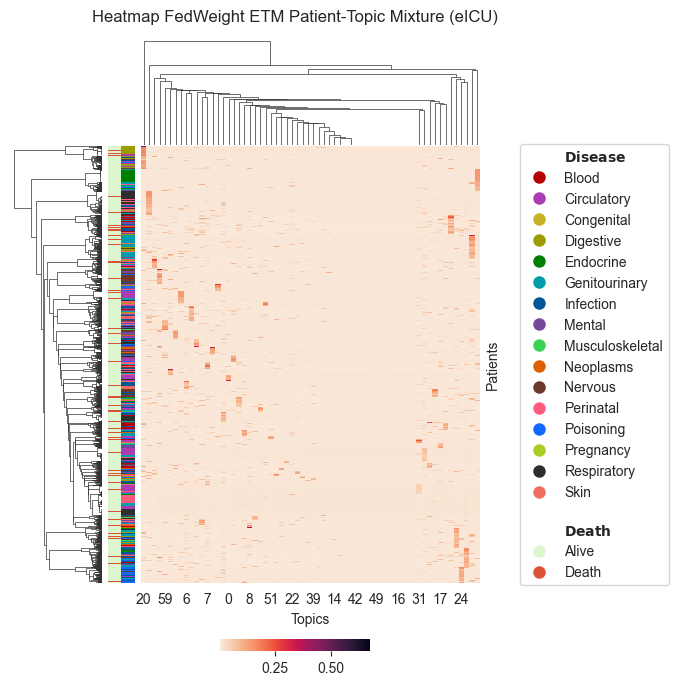

In [36]:
from scipy.cluster.hierarchy import linkage
import matplotlib.pyplot as plt
import seaborn as sns

weighted_eicu_train_tensor = torch.tensor(weighted_eicu_train_icds)

_, eicu_train_theta_weighted, _ = weighted_eicu_client_model.get_theta(weighted_eicu_train_tensor)
eicu_train_theta_weighted = eicu_train_theta_weighted.data.cpu().numpy()

X_eicu_train = eicu_train_theta_weighted[weighted_eicu_train_readmit_row_ids]
eicu_icd_input = weighted_eicu_train_tensor[weighted_eicu_train_readmit_row_ids]

eicu_most_common_icd_names, eicu_least_common_icd_names = find_common_icds(eicu_icd_input, feature_sums_tensor)

unique_diseases = np.unique(eicu_least_common_icd_names)
disease_row_colors = pd.Series(eicu_least_common_icd_names).map(disease_color_map).to_numpy()

eicu_train_death_data_series = pd.Series(weighted_eicu_train_label_deaths, name='Death')
death_row_colors = eicu_train_death_data_series.map(death_color_map).to_numpy()

row_colors = pd.DataFrame({'Death': death_row_colors, 'Disease': disease_row_colors}).to_numpy().T

# Create a seaborn clustermap
plt.clf()
row_clusters = linkage(X_eicu_train, method='ward')
col_clusters = linkage(X_eicu_train.T, method='ward')
g = sns.clustermap(X_eicu_train, row_linkage=row_clusters, col_linkage=col_clusters, 
                   figsize=(5, 6),
                   yticklabels=False, cmap='rocket_r',
                   cbar_kws={'orientation': 'horizontal', 'pad': 0.1, 'shrink': 0.6},
                   cbar_pos=(0.45, -0.05, 0.3, 0.02),
                   row_colors=row_colors)

g.fig.suptitle(f'Heatmap FedWeight ETM Patient-Topic Mixture (eICU)',
               fontsize=12, x=0.6, y=1.02)
g.ax_heatmap.set_xlabel('Topics')
g.ax_heatmap.set_ylabel('Patients')

disease_title_legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="white", 
                             markersize=10, label="$\\mathbf{Disease}$")]
disease_legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=disease_color_map[disease],
                             markersize=10, label=disease) for disease in unique_diseases]

death_title_legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="white", 
                            markersize=10, label="\n$\\mathbf{Death}$")]
death_legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=death_color_map[death], 
                            markersize=10, label=('Death' if death == 1 else 'Alive')) for death in [0, 1]]

legend_patches = disease_title_legend_patches + disease_legend_patches + death_title_legend_patches + death_legend_patches

plt.legend(handles=legend_patches, bbox_to_anchor=(2.0, 5.5), loc='lower left', borderaxespad=0.)

plt.show()
plt.close()

Training AUPRC: 0.18957822370834065
Training AUROC: 0.6330411556811932
[-5.57729975e-01 -9.66365522e-02 -1.55708765e+00  1.84476370e+00
  1.11001977e-01  2.97936500e-02  1.89798997e-01 -4.97600810e-01
  5.06805800e-01  8.39920085e-02 -9.72246688e-02 -3.44706032e-02
  5.49420090e-01 -1.92369061e-01 -8.74501704e-02 -1.03161334e-01
 -9.69132979e-02 -4.21720267e-01 -2.30814687e-01 -1.02669347e-01
  5.63103489e-01 -5.21908095e-02  1.01370936e-03  1.20175145e-02
  2.25882215e-02  5.66902375e-01 -1.31205729e-01  1.70393491e-01
  9.42428735e-01  1.04766903e+00 -9.47486150e-02  4.41303206e-01
  2.45586983e+00 -4.53336647e-02 -1.06808461e-01 -8.48323259e-03
  3.89460911e-02 -9.55893494e-01  2.17110835e-01 -1.44887854e-01
  2.76008266e-01 -5.08126022e-01 -9.71141897e-02 -9.71884352e-02
 -2.42043800e+00 -9.41809126e-02  2.47061092e-01 -1.85168248e-01
  3.95858555e-01 -9.72905104e-02 -1.00880738e-01 -7.69858015e-01
  3.33740286e-01  2.86773562e-01 -2.56146282e-01 -1.47183605e-01
  7.72246576e-01 -3

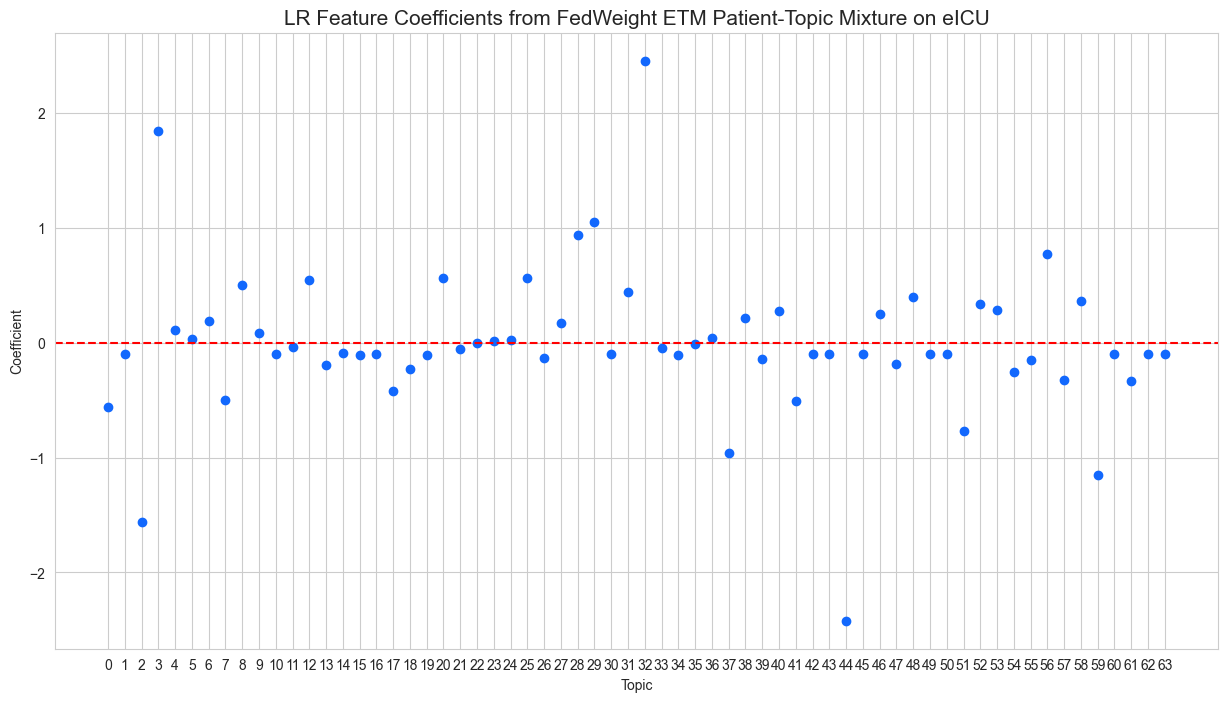

In [46]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score

knn_eicu_weighted_lr = LogisticRegression()
knn_eicu_weighted_lr.fit(X_eicu_train, weighted_eicu_train_label_deaths)

predicted_probs = knn_eicu_weighted_lr.predict_proba(X_eicu_train)[:, 1]  # Probabilities for class 1
auprc = average_precision_score(weighted_eicu_train_label_deaths, predicted_probs)
print(f'Training AUPRC: {auprc}')
auroc = roc_auc_score(weighted_eicu_train_label_deaths, predicted_probs)
print(f'Training AUROC: {auroc}')

coefficients = knn_eicu_weighted_lr.coef_[0]
print(coefficients)

plt.figure(figsize=(15, 8))
plt.title("LR Feature Coefficients from FedWeight ETM Patient-Topic Mixture on eICU", fontsize=15)
plt.scatter(range(len(coefficients)), coefficients, color='#1268fd')
plt.axhline(0, color='red', linestyle='--')
plt.xticks(range(len(coefficients)))
plt.xlabel("Topic")
plt.ylabel("Coefficient")
plt.show()

<Figure size 640x480 with 0 Axes>

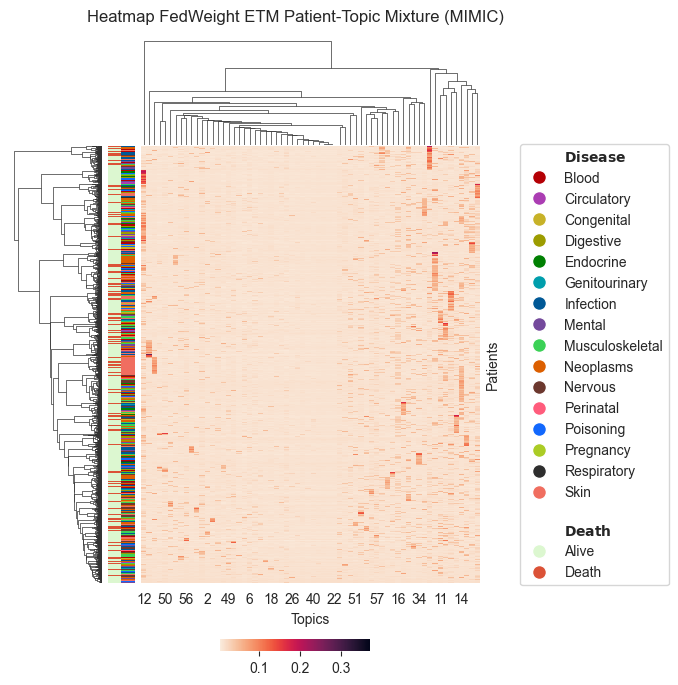

In [26]:
from scipy.cluster.hierarchy import linkage
import matplotlib.pyplot as plt
import seaborn as sns

weighted_mimic_train_tensor = torch.tensor(weighted_mimic_train_icds)

_, mimic_train_theta_weighted, _ = weighted_mimic_client_model.get_theta(weighted_mimic_train_tensor)
mimic_train_theta_weighted = mimic_train_theta_weighted.data.cpu().numpy()

X_mimic_train = mimic_train_theta_weighted[weighted_mimic_train_readmit_row_ids]
mimic_icd_input = weighted_mimic_train_tensor[weighted_mimic_train_readmit_row_ids]

mimic_most_common_icd_names, mimic_least_common_icd_names = find_common_icds(mimic_icd_input, feature_sums_tensor)

unique_diseases = np.unique(mimic_least_common_icd_names)
disease_row_colors = pd.Series(mimic_least_common_icd_names).map(disease_color_map).to_numpy()

mimic_train_death_data_series = pd.Series(weighted_mimic_train_label_deaths, name='Death')
death_row_colors = mimic_train_death_data_series.map(death_color_map).to_numpy()

row_colors = pd.DataFrame({'Death': death_row_colors, 'Disease': disease_row_colors}).to_numpy().T

# Create a seaborn clustermap
plt.clf()
row_clusters = linkage(X_mimic_train, method='ward')
col_clusters = linkage(X_mimic_train.T, method='ward')
g = sns.clustermap(X_mimic_train, row_linkage=row_clusters, col_linkage=col_clusters, 
                   figsize=(5, 6),
                   yticklabels=False, cmap='rocket_r',
                   cbar_kws={'orientation': 'horizontal', 'pad': 0.1, 'shrink': 0.6},
                   cbar_pos=(0.45, -0.05, 0.3, 0.02),
                   row_colors=row_colors)

g.fig.suptitle(f'Heatmap FedWeight ETM Patient-Topic Mixture (MIMIC)',
               fontsize=12, x=0.6, y=1.02)
g.ax_heatmap.set_xlabel('Topics')
g.ax_heatmap.set_ylabel('Patients')

disease_title_legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="white", 
                             markersize=10, label="$\\mathbf{Disease}$")]
disease_legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=disease_color_map[disease],
                             markersize=10, label=disease) for disease in unique_diseases]

death_title_legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="white", 
                            markersize=10, label="\n$\\mathbf{Death}$")]
death_legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=death_color_map[death], 
                            markersize=10, label=('Death' if death == 1 else 'Alive')) for death in [0, 1]]

legend_patches = disease_title_legend_patches + disease_legend_patches + death_title_legend_patches + death_legend_patches

plt.legend(handles=legend_patches, bbox_to_anchor=(2.0, 5.5), loc='lower left', borderaxespad=0.)

plt.show()
plt.close()

Training AUPRC: 0.29705025686724945
Training AUROC: 0.6263213960907862
[ 0.19752029 -0.22040901  0.6053032   0.64140742 -0.08905546 -0.75074814
 -0.26578343 -0.18652846 -0.22683268 -0.20692949  0.63286253  0.88744793
 -2.26841903 -0.52281148 -0.51684839  2.68755901  1.58664368 -0.30950704
 -0.16296578 -0.60002307  0.63088    -0.31723465 -0.21840186  1.0012101
 -0.78465844 -1.1787194  -0.24306413 -0.02940214 -0.65621337 -0.07776699
  0.03087725 -0.46127228  0.07682826 -0.77492071 -0.14157936  0.13214083
  0.03069746 -0.2780159   1.1097167  -1.36929542 -0.10990406  0.34833683
 -0.62127205  0.81305373  1.93951875  0.00272022 -0.12496758  1.46258291
  1.08120319 -0.64954582 -0.59171463 -0.57366944 -0.49777266  1.16928687
 -0.34770402 -0.1181992   0.02790393  0.28280379 -0.63804307 -0.29880156
  0.37811315  0.48750632 -0.79800177 -0.03327221]


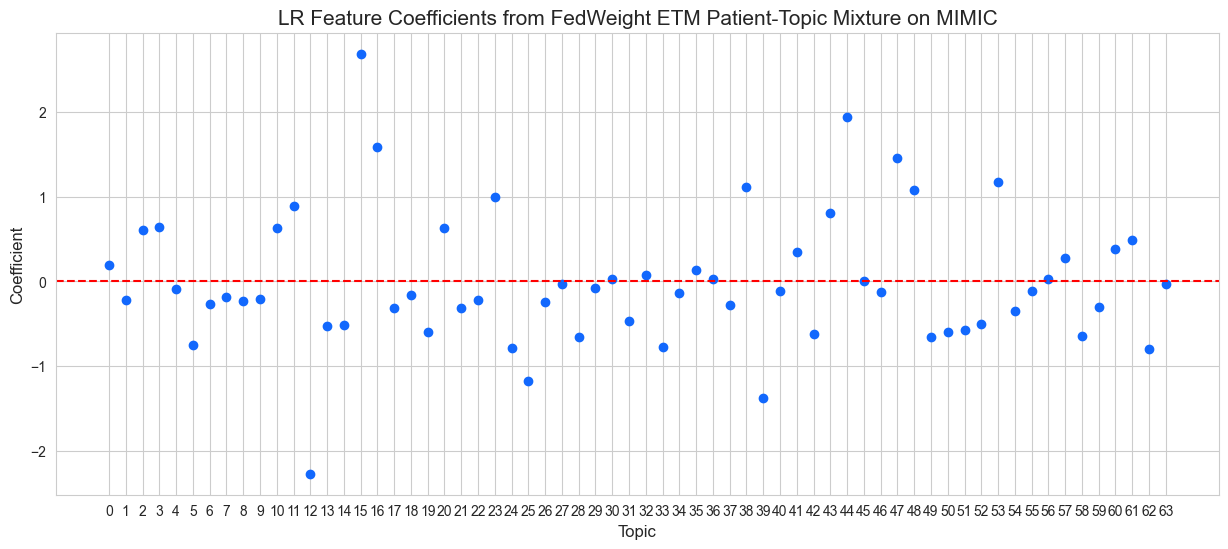

In [56]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

knn_mimic_weighted_lr = LogisticRegression()
knn_mimic_weighted_lr.fit(X_mimic_train, weighted_mimic_train_label_deaths)

predicted_probs = knn_mimic_weighted_lr.predict_proba(X_mimic_train)[:, 1]  # Probabilities for class 1
auprc = average_precision_score(weighted_mimic_train_label_deaths, predicted_probs)
print(f'Training AUPRC: {auprc}')
auroc = roc_auc_score(weighted_mimic_train_label_deaths, predicted_probs)
print(f'Training AUROC: {auroc}')

coefficients = knn_mimic_weighted_lr.coef_[0]
print(coefficients)

plt.figure(figsize=(15, 6))
plt.title("LR Feature Coefficients from FedWeight ETM Patient-Topic Mixture on MIMIC", fontsize=15)
plt.scatter(range(len(coefficients)), coefficients, color='#1268fd')
plt.axhline(0, color='red', linestyle='--')
plt.xticks(range(len(coefficients)))
plt.xlabel("Topic", fontsize=12)
plt.ylabel("Coefficient", fontsize=12)
plt.show()

In [28]:
# from scipy.stats import ranksums
from scipy.stats import mannwhitneyu # Wilcoxon rank-sum test (one-sided Mann-Whitney U test)

topic_death_mimic_p_values = []
topic_death_eicu_p_values = []

for topic in range(num_topics):
    X_mimic_train_topic = X_mimic_train[:, topic]
    X_mimic_train_topic_death = X_mimic_train_topic[weighted_mimic_train_label_deaths == 1]
    X_mimic_train_topic_alive = X_mimic_train_topic[weighted_mimic_train_label_deaths == 0]

    print("Topc : ", topic, " Death : ", X_mimic_train_topic_death.shape, " Alive : ", X_mimic_train_topic_alive.shape)

    # Perform the Wilcoxon test
    _, mimic_p_value = mannwhitneyu(X_mimic_train_topic_death, X_mimic_train_topic_alive, alternative="greater")
    neg_log_mimic_p_value = -np.log10(mimic_p_value)
    topic_death_mimic_p_values.append(neg_log_mimic_p_value)

    X_eicu_train_topic = X_eicu_train[:, topic]
    X_eicu_train_topic_death = X_eicu_train_topic[weighted_eicu_train_label_deaths == 1]
    X_eicu_train_topic_alive = X_eicu_train_topic[weighted_eicu_train_label_deaths == 0]

    # Perform the Wilcoxon test
    _, eicu_p_value = mannwhitneyu(X_eicu_train_topic_death, X_eicu_train_topic_alive, alternative="greater")
    neg_log_eicu_p_value = -np.log10(eicu_p_value)
    topic_death_eicu_p_values.append(neg_log_eicu_p_value)

Topc :  0  Death :  (1197,)  Alive :  (4649,)
Topc :  1  Death :  (1197,)  Alive :  (4649,)
Topc :  2  Death :  (1197,)  Alive :  (4649,)
Topc :  3  Death :  (1197,)  Alive :  (4649,)
Topc :  4  Death :  (1197,)  Alive :  (4649,)
Topc :  5  Death :  (1197,)  Alive :  (4649,)
Topc :  6  Death :  (1197,)  Alive :  (4649,)
Topc :  7  Death :  (1197,)  Alive :  (4649,)
Topc :  8  Death :  (1197,)  Alive :  (4649,)
Topc :  9  Death :  (1197,)  Alive :  (4649,)
Topc :  10  Death :  (1197,)  Alive :  (4649,)
Topc :  11  Death :  (1197,)  Alive :  (4649,)
Topc :  12  Death :  (1197,)  Alive :  (4649,)
Topc :  13  Death :  (1197,)  Alive :  (4649,)
Topc :  14  Death :  (1197,)  Alive :  (4649,)
Topc :  15  Death :  (1197,)  Alive :  (4649,)
Topc :  16  Death :  (1197,)  Alive :  (4649,)
Topc :  17  Death :  (1197,)  Alive :  (4649,)
Topc :  18  Death :  (1197,)  Alive :  (4649,)
Topc :  19  Death :  (1197,)  Alive :  (4649,)
Topc :  20  Death :  (1197,)  Alive :  (4649,)
Topc :  21  Death :  (1

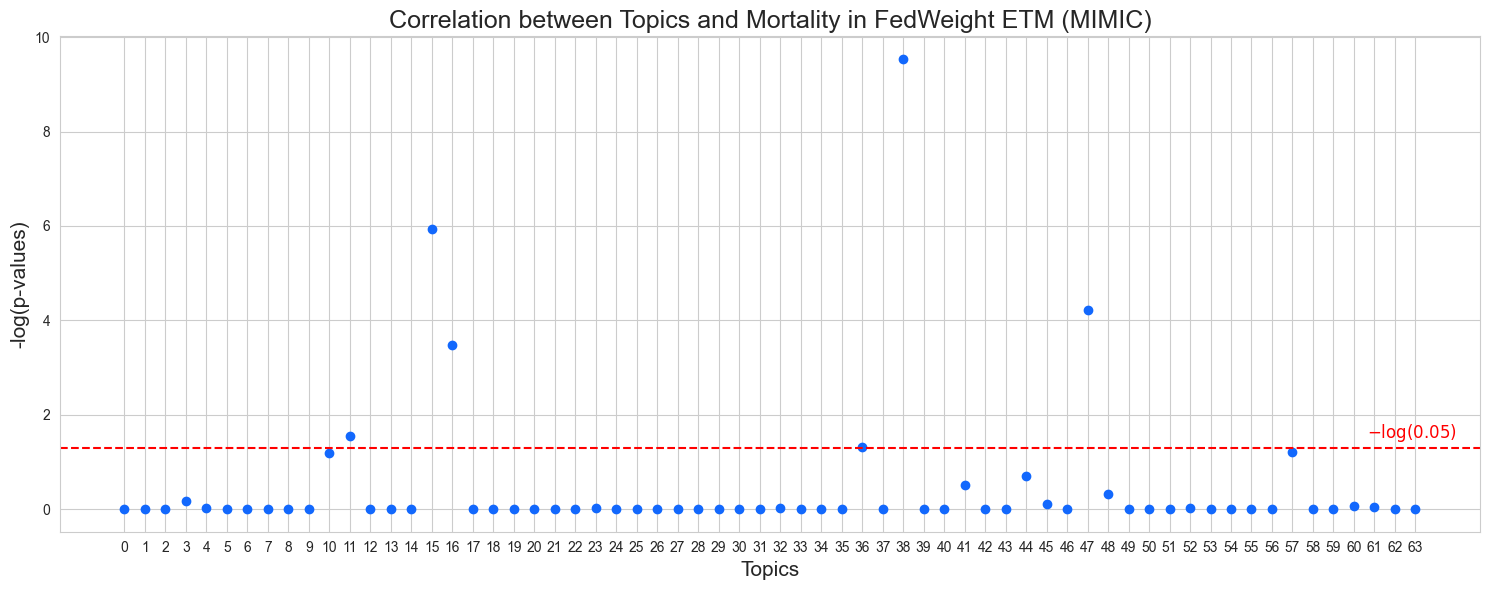

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

plt.scatter(range(len(topic_death_mimic_p_values)), topic_death_mimic_p_values, 
            color='#1268fd')

plt.axhline(-np.log10(0.05), color='red', linestyle='--')
plt.text(65, -np.log10(0.05) + 0.2, '$-\log(0.05)$', color='red', fontsize=12, horizontalalignment='right')

plt.xlabel("Topics", fontsize=15)
plt.ylabel("-log(p-values)", fontsize=15)
plt.title("Correlation between Topics and Mortality in FedWeight ETM (MIMIC)", fontsize=18)

plt.xticks(range(num_topics), range(num_topics))

plt.grid(True)
plt.tight_layout()
plt.show()

In [71]:
topic_death_mimic_p_values_max_topic = np.argmax(topic_death_mimic_p_values)
topic_death_mimic_p_values_min_topic = np.argmin(topic_death_mimic_p_values)

topic_death_mimic_top_5_most_significant_topics = np.argsort(topic_death_mimic_p_values)[-5:]  # Lowest p-values
topic_death_mimic_top_5_least_significant_topics = np.argsort(topic_death_mimic_p_values)[:5] # Highest p-values

print("MIMIC most significant topic: ", topic_death_mimic_p_values_max_topic)
print("MIMIC least significant topic: ", topic_death_mimic_p_values_min_topic)

print("MIMIC top 5 most significant topics: ", topic_death_mimic_top_5_most_significant_topics)
print("MIMIC top 5 least significant topics: ", topic_death_mimic_top_5_least_significant_topics)

MIMIC most significant topic:  38
MIMIC least significant topic:  17
MIMIC top 5 most significant topics:  [11 16 47 15 38]
MIMIC top 5 least significant topics:  [17 26 62 42 39]


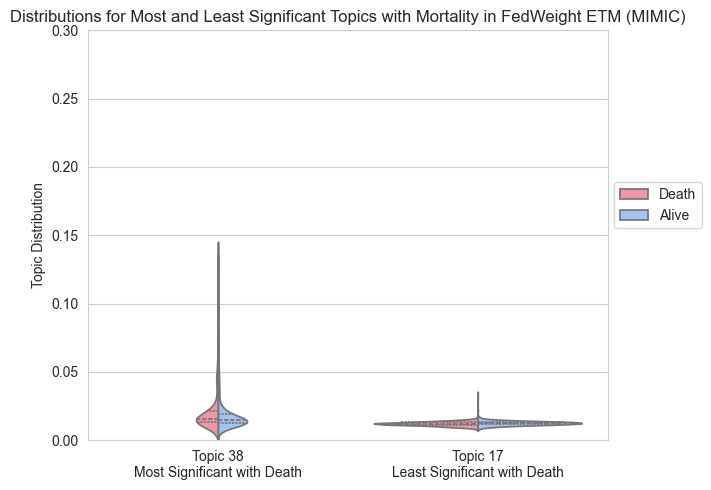

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

X_mimic_train_topic_max_topic = X_mimic_train[:, topic_death_mimic_p_values_max_topic]
X_mimic_train_topic_max_topic_death = X_mimic_train_topic_max_topic[weighted_mimic_train_label_deaths == 1]
X_mimic_train_topic_max_topic_alive = X_mimic_train_topic_max_topic[weighted_mimic_train_label_deaths == 0]

X_mimic_train_topic_min_topic = X_mimic_train[:, topic_death_mimic_p_values_min_topic]
X_mimic_train_topic_min_topic_death = X_mimic_train_topic_min_topic[weighted_mimic_train_label_deaths == 1]
X_mimic_train_topic_min_topic_alive = X_mimic_train_topic_min_topic[weighted_mimic_train_label_deaths == 0]

total_mimic_train_patients_count = X_mimic_train.shape[0]
total_mimic_train_death_count = X_mimic_train_topic_max_topic_death.shape[0]
total_mimic_train_alive_count = X_mimic_train_topic_max_topic_alive.shape[0]

custom_violin_palette = {
    "Death": "#ff879e",
    "Alive": "#96c1ff"
}

group_1 = {
    "Topic": [f"Topic {topic_death_mimic_p_values_max_topic}\nMost Significant with Death"] * total_mimic_train_patients_count,
    "Outcome": ["Death"] * total_mimic_train_death_count + ["Alive"] * total_mimic_train_alive_count,
    "Topic Distribution": np.concatenate([X_mimic_train_topic_max_topic_death, X_mimic_train_topic_max_topic_alive]),
}

group_2 = {
    "Topic": [f"Topic {topic_death_mimic_p_values_min_topic}\nLeast Significant with Death"] * total_mimic_train_patients_count,
    "Outcome": ["Death"] * total_mimic_train_death_count + ["Alive"] * total_mimic_train_alive_count,
    "Topic Distribution": np.concatenate([X_mimic_train_topic_min_topic_death, X_mimic_train_topic_min_topic_alive]),
}

# Combine into a single DataFrame
data = pd.concat([pd.DataFrame(group_1), pd.DataFrame(group_2)], ignore_index=True)

# Plot grouped violin plots
plt.figure(figsize=(7, 5))
sns.violinplot(
    x="Topic",
    y="Topic Distribution",
    hue="Outcome",
    data=data,
    split=True,
    inner="quart",
    palette=custom_violin_palette,
)

plt.title("Distributions for Most and Least Significant Topics with Mortality in FedWeight ETM (MIMIC)")
plt.legend(bbox_to_anchor=(1.0, 0.5), loc='lower left')
plt.xlabel("")
plt.tight_layout()
plt.ylim(0, 0.3)
plt.show()

<Figure size 640x480 with 0 Axes>

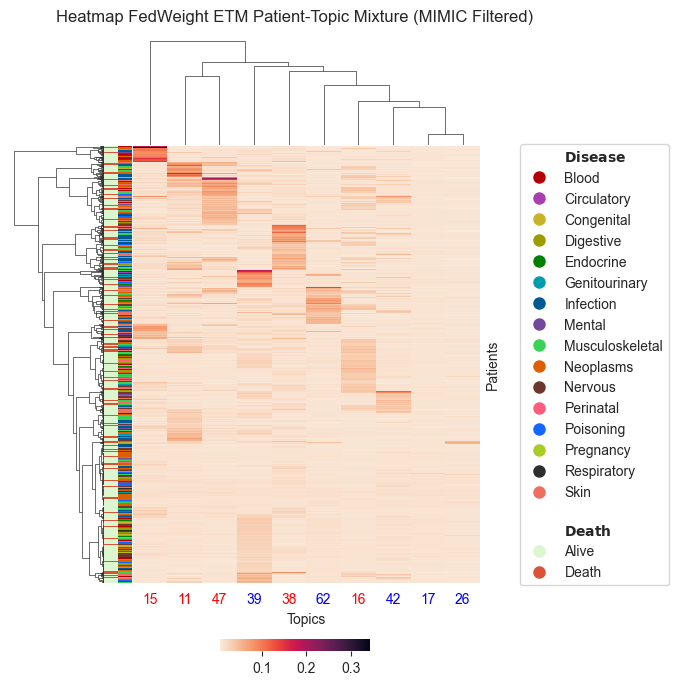

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

mimic_most_common_icd_names, mimic_least_common_icd_names = find_common_icds(mimic_icd_input, feature_sums_tensor)

unique_diseases = np.unique(mimic_least_common_icd_names)
disease_row_colors = pd.Series(mimic_least_common_icd_names).map(disease_color_map).to_numpy()

mimic_train_death_data_series = pd.Series(weighted_mimic_train_label_deaths, name='Death')
death_row_colors = mimic_train_death_data_series.map(death_color_map).to_numpy()

row_colors = pd.DataFrame({'Death': death_row_colors, 'Disease': disease_row_colors}).to_numpy().T

# Assuming topic_death_mimic_top_5_most_significant_topics and topic_death_mimic_top_5_least_significant_topics are already defined
# Combine the top 5 most and least significant topics
topic_death_mimic_top_5_most_and_least_significant_topics = np.concatenate(
    (topic_death_mimic_top_5_most_significant_topics, topic_death_mimic_top_5_least_significant_topics)
)

# Filter the matrix X_mimic_train (shape N x K, where K is topics)
# Assuming X_mimic_train is a NumPy array
X_mimic_train_filtered = X_mimic_train[:, topic_death_mimic_top_5_most_and_least_significant_topics]

# Create a seaborn clustermap
plt.clf()
row_clusters = linkage(X_mimic_train_filtered, method='ward')
col_clusters = linkage(X_mimic_train_filtered.T, method='ward')
g = sns.clustermap(X_mimic_train_filtered, row_linkage=row_clusters, col_linkage=col_clusters, 
                   figsize=(5, 6),
                   yticklabels=False, 
                   xticklabels=topic_death_mimic_top_5_most_and_least_significant_topics,
                   cmap='rocket_r',
                   cbar_kws={'orientation': 'horizontal', 'pad': 0.1, 'shrink': 0.6},
                   cbar_pos=(0.45, -0.05, 0.3, 0.02),
                   row_colors=row_colors)

g.fig.suptitle(f'Heatmap FedWeight ETM Patient-Topic Mixture (MIMIC Filtered)',
               fontsize=12, x=0.6, y=1.02)
g.ax_heatmap.set_xlabel('Topics')
g.ax_heatmap.set_ylabel('Patients')

xtick_labels = g.ax_heatmap.get_xticklabels()
for label in xtick_labels:
    topic = int(label.get_text())  # Extract topic number
    if topic in topic_death_mimic_top_5_most_significant_topics:
        label.set_color('red')  # Use red for most significant topics
    else:
        label.set_color('blue')  # Use blue for others

disease_title_legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="white", 
                             markersize=10, label="$\\mathbf{Disease}$")]
disease_legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=disease_color_map[disease],
                             markersize=10, label=disease) for disease in unique_diseases]

death_title_legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="white", 
                            markersize=10, label="\n$\\mathbf{Death}$")]
death_legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=death_color_map[death], 
                            markersize=10, label=('Death' if death == 1 else 'Alive')) for death in [0, 1]]

legend_patches = disease_title_legend_patches + disease_legend_patches + death_title_legend_patches + death_legend_patches

plt.legend(handles=legend_patches, bbox_to_anchor=(2.0, 5.5), loc='lower left', borderaxespad=0.)

plt.show()
plt.close()


In [78]:
X_mimic_train_filtered.shape

(5846, 64)

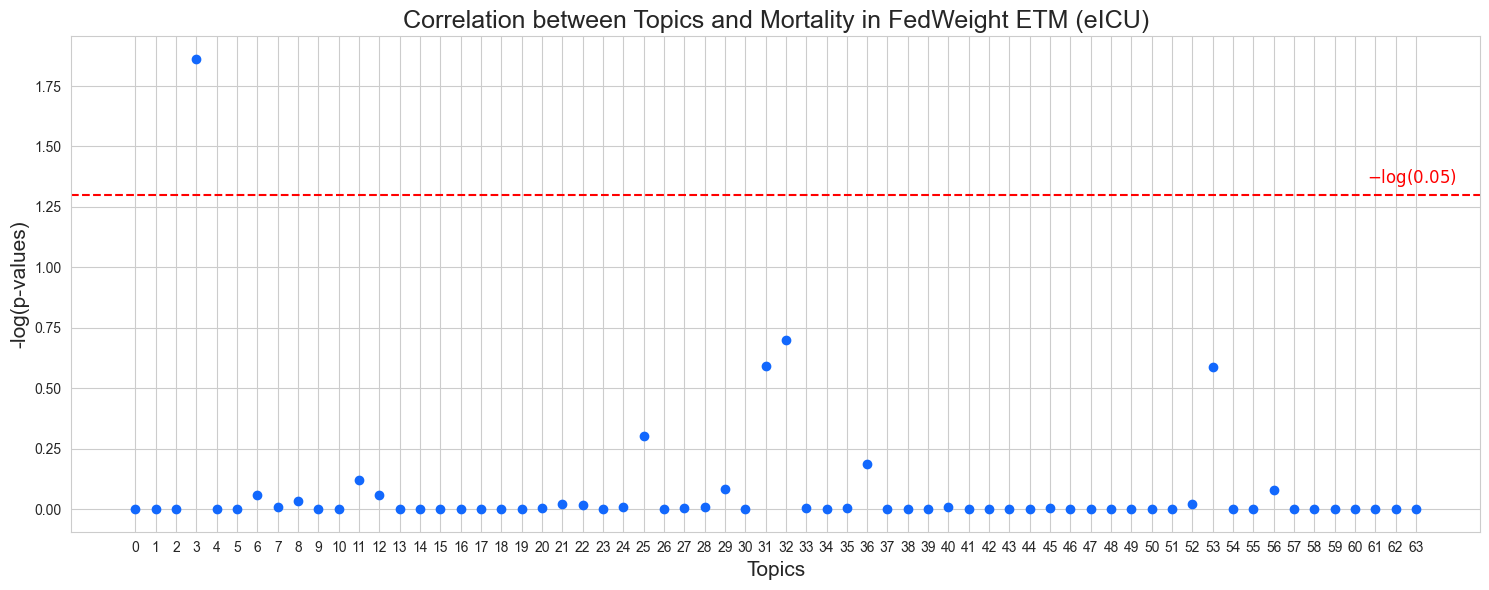

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

plt.scatter(range(len(topic_death_eicu_p_values)), topic_death_eicu_p_values, 
            color='#1268fd')

plt.axhline(-np.log10(0.05), color='red', linestyle='--')
plt.text(65, -np.log10(0.05) + 0.05, '$-\log(0.05)$', color='red', fontsize=12, horizontalalignment='right')

plt.xlabel("Topics", fontsize=15)
plt.ylabel("-log(p-values)", fontsize=15)
plt.title("Correlation between Topics and Mortality in FedWeight ETM (eICU)", fontsize=18)

plt.xticks(range(num_topics), range(num_topics))

plt.grid(True)
plt.tight_layout()
plt.show()

In [72]:
topic_death_eicu_p_values_max_topic = np.argmax(topic_death_eicu_p_values)
topic_death_eicu_p_values_min_topic = np.argmin(topic_death_eicu_p_values)

topic_death_eicu_top_5_most_significant_topics = np.argsort(topic_death_eicu_p_values)[-5:]  # Lowest p-values
topic_death_eicu_top_5_least_significant_topics = np.argsort(topic_death_eicu_p_values)[:5] # Highest p-values

print("eICU most significant topic: ", topic_death_eicu_p_values_max_topic)
print("eICU least significant topic: ", topic_death_eicu_p_values_min_topic)

print("eICU top 5 most significant topics: ", topic_death_eicu_top_5_most_significant_topics)
print("eICU top 5 least significant topics: ", topic_death_eicu_top_5_least_significant_topics)

eICU most significant topic:  3
eICU least significant topic:  51
eICU top 5 most significant topics:  [25 53 31 32  3]
eICU top 5 least significant topics:  [51  2 44  0 59]


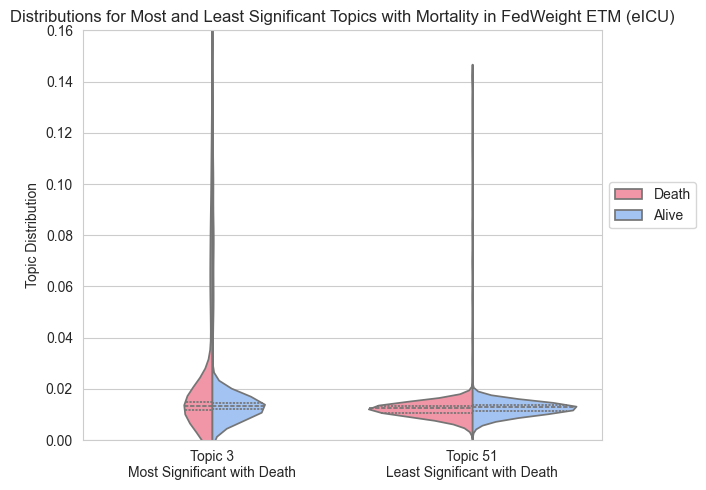

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

X_eicu_train_topic_max_topic = X_eicu_train[:, topic_death_eicu_p_values_max_topic]
X_eicu_train_topic_max_topic_death = X_eicu_train_topic_max_topic[weighted_eicu_train_label_deaths == 1]
X_eicu_train_topic_max_topic_alive = X_eicu_train_topic_max_topic[weighted_eicu_train_label_deaths == 0]

X_eicu_train_topic_min_topic = X_eicu_train[:, topic_death_eicu_p_values_min_topic]
X_eicu_train_topic_min_topic_death = X_eicu_train_topic_min_topic[weighted_eicu_train_label_deaths == 1]
X_eicu_train_topic_min_topic_alive = X_eicu_train_topic_min_topic[weighted_eicu_train_label_deaths == 0]

total_eicu_train_patients_count = X_eicu_train.shape[0]
total_eicu_train_death_count = X_eicu_train_topic_max_topic_death.shape[0]
total_eicu_train_alive_count = X_eicu_train_topic_max_topic_alive.shape[0]

custom_violin_palette = {
    "Death": "#ff879e",
    "Alive": "#96c1ff"
}

group_1 = {
    "Topic": [f"Topic {topic_death_eicu_p_values_max_topic}\nMost Significant with Death"] * total_eicu_train_patients_count,
    "Outcome": ["Death"] * total_eicu_train_death_count + ["Alive"] * total_eicu_train_alive_count,
    "Topic Distribution": np.concatenate([X_eicu_train_topic_max_topic_death, X_eicu_train_topic_max_topic_alive]),
}

group_2 = {
    "Topic": [f"Topic {topic_death_eicu_p_values_min_topic}\nLeast Significant with Death"] * total_eicu_train_patients_count,
    "Outcome": ["Death"] * total_eicu_train_death_count + ["Alive"] * total_eicu_train_alive_count,
    "Topic Distribution": np.concatenate([X_eicu_train_topic_min_topic_death, X_eicu_train_topic_min_topic_alive]),
}

# Combine into a single DataFrame
data = pd.concat([pd.DataFrame(group_1), pd.DataFrame(group_2)], ignore_index=True)

# Plot grouped violin plots
plt.figure(figsize=(7, 5))
sns.violinplot(
    x="Topic",
    y="Topic Distribution",
    hue="Outcome",
    data=data,
    split=True,
    inner="quart",
    palette=custom_violin_palette,
)

plt.title("Distributions for Most and Least Significant Topics with Mortality in FedWeight ETM (eICU)")
plt.legend(bbox_to_anchor=(1.0, 0.5), loc='lower left')
plt.xlabel("")
plt.tight_layout()
plt.ylim(0, 0.16)
plt.show()

In [73]:
X_mimic_train.shape

(5846, 64)

<Figure size 640x480 with 0 Axes>

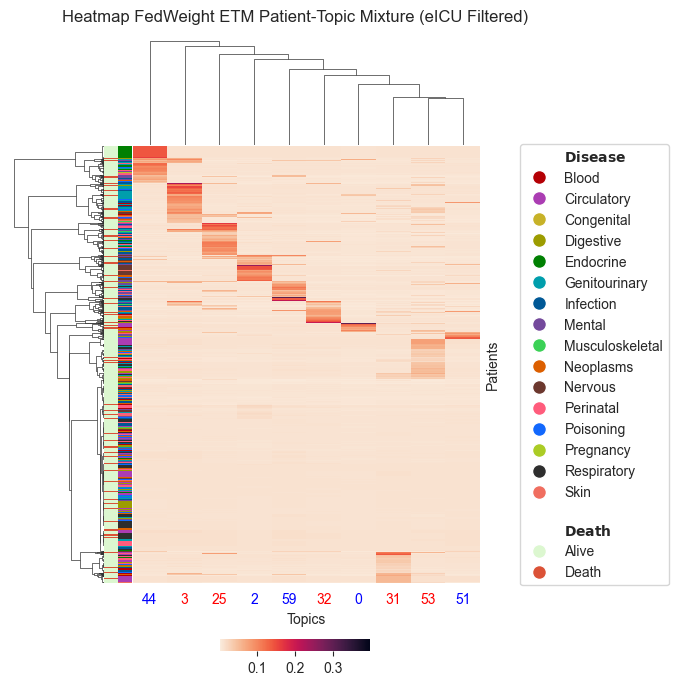

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

eicu_most_common_icd_names, eicu_least_common_icd_names = find_common_icds(eicu_icd_input, feature_sums_tensor)

unique_diseases = np.unique(eicu_least_common_icd_names)
disease_row_colors = pd.Series(eicu_least_common_icd_names).map(disease_color_map).to_numpy()

eicu_train_death_data_series = pd.Series(weighted_eicu_train_label_deaths, name='Death')
death_row_colors = eicu_train_death_data_series.map(death_color_map).to_numpy()

row_colors = pd.DataFrame({'Death': death_row_colors, 'Disease': disease_row_colors}).to_numpy().T

# Assuming topic_death_eicu_top_5_most_significant_topics and topic_death_eicu_top_5_least_significant_topics are already defined
# Combine the top 5 most and least significant topics
topic_death_eicu_top_5_most_and_least_significant_topics = np.concatenate(
    (topic_death_eicu_top_5_most_significant_topics, topic_death_eicu_top_5_least_significant_topics)
)

# Filter the matrix X_eicu_train (shape N x K, where K is topics)
# Assuming X_eicu_train is a NumPy array
X_eicu_train_filtered = X_eicu_train[:, topic_death_eicu_top_5_most_and_least_significant_topics]

# Create a seaborn clustermap
plt.clf()
row_clusters = linkage(X_eicu_train_filtered, method='ward')
col_clusters = linkage(X_eicu_train_filtered.T, method='ward')
g = sns.clustermap(X_eicu_train_filtered, row_linkage=row_clusters, col_linkage=col_clusters, 
                   figsize=(5, 6),
                   yticklabels=False, 
                   xticklabels=topic_death_eicu_top_5_most_and_least_significant_topics,
                   cmap='rocket_r',
                   cbar_kws={'orientation': 'horizontal', 'pad': 0.1, 'shrink': 0.6},
                   cbar_pos=(0.45, -0.05, 0.3, 0.02),
                   row_colors=row_colors)

g.fig.suptitle(f'Heatmap FedWeight ETM Patient-Topic Mixture (eICU Filtered)',
               fontsize=12, x=0.6, y=1.02)
g.ax_heatmap.set_xlabel('Topics')
g.ax_heatmap.set_ylabel('Patients')

xtick_labels = g.ax_heatmap.get_xticklabels()
for label in xtick_labels:
    topic = int(label.get_text())  # Extract topic number
    if topic in topic_death_eicu_top_5_most_significant_topics:
        label.set_color('red')  # Use red for most significant topics
    else:
        label.set_color('blue')  # Use blue for others

disease_title_legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="white", 
                             markersize=10, label="$\\mathbf{Disease}$")]
disease_legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=disease_color_map[disease],
                             markersize=10, label=disease) for disease in unique_diseases]

death_title_legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="white", 
                            markersize=10, label="\n$\\mathbf{Death}$")]
death_legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=death_color_map[death], 
                            markersize=10, label=('Death' if death == 1 else 'Alive')) for death in [0, 1]]

legend_patches = disease_title_legend_patches + disease_legend_patches + death_title_legend_patches + death_legend_patches

plt.legend(handles=legend_patches, bbox_to_anchor=(2.0, 5.5), loc='lower left', borderaxespad=0.)

plt.show()
plt.close()
